# imports

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [95]:
train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

# Function to plot the distribution of classes

In [96]:
def plot_class_distribution(data, title):
    plt.figure(figsize=(20, 10))
    sns.countplot(x=data)
    plt.title(title)
    plt.show()

# Plot initial class distribution

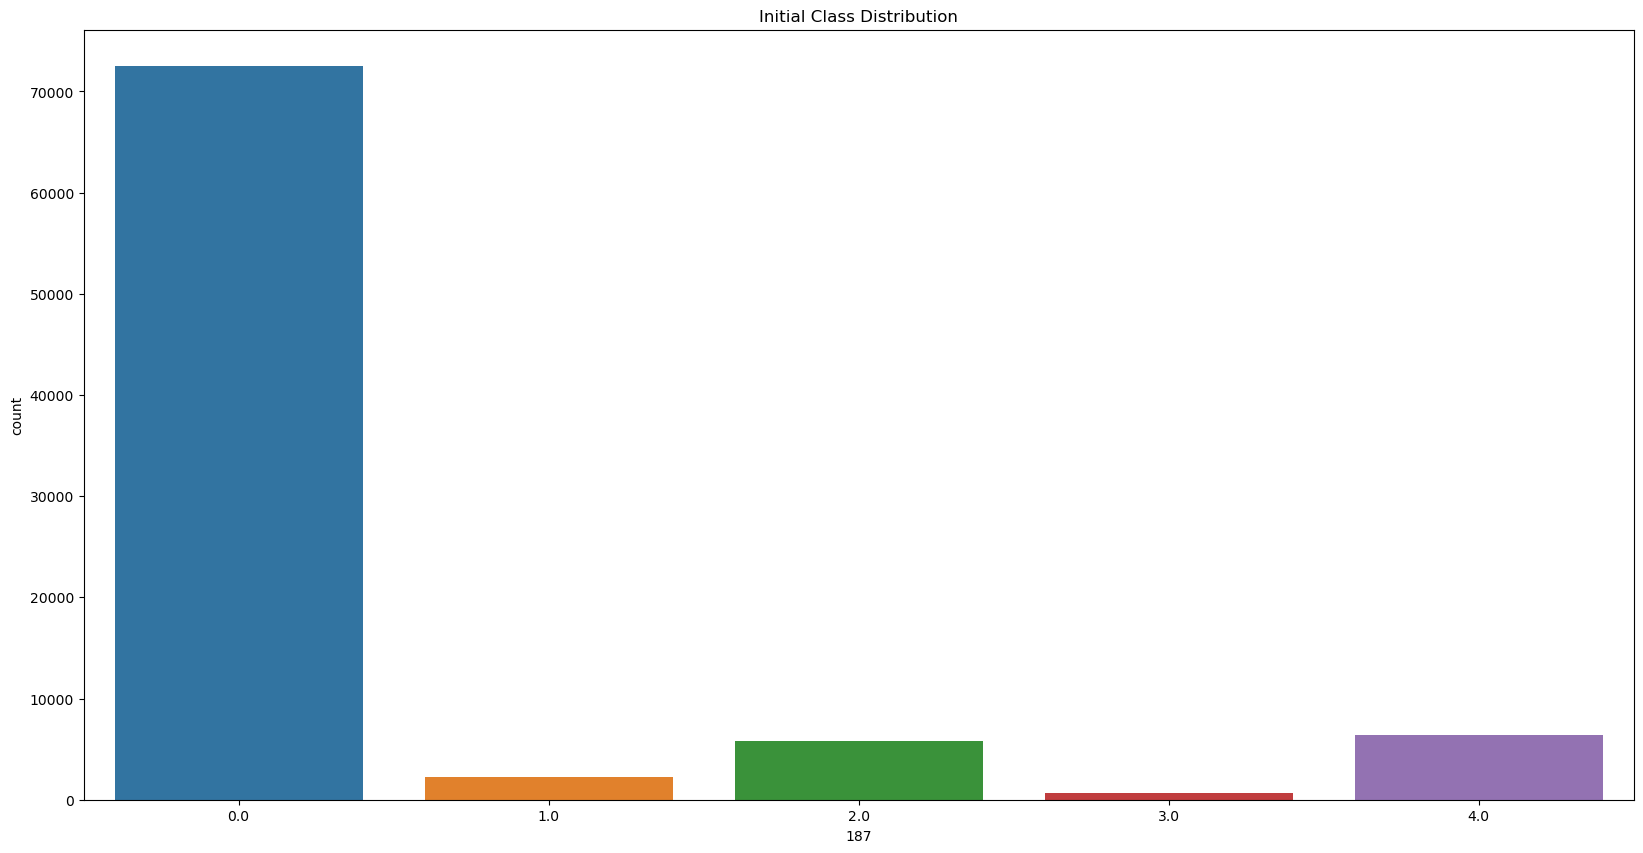

In [97]:
plot_class_distribution(train_df[187], "Initial Class Distribution")

# Upsampling minority classes

In [98]:
from sklearn.utils import resample
def upsample_class(df, class_label, n_samples=20000):
    df_class = df[df[187] == class_label]
    return resample(df_class, replace=True, n_samples=n_samples, random_state=42)

# Upsample each class

In [99]:
df_0 = upsample_class(train_df, 0)
df_1 = upsample_class(train_df, 1)
df_2 = upsample_class(train_df, 2)
df_3 = upsample_class(train_df, 3)
df_4 = upsample_class(train_df, 4)

# Combine all classes back into a single DataFrame

In [100]:
train_df_balanced = pd.concat([df_0, df_1, df_2, df_3, df_4])

# Plot balanced class distribution

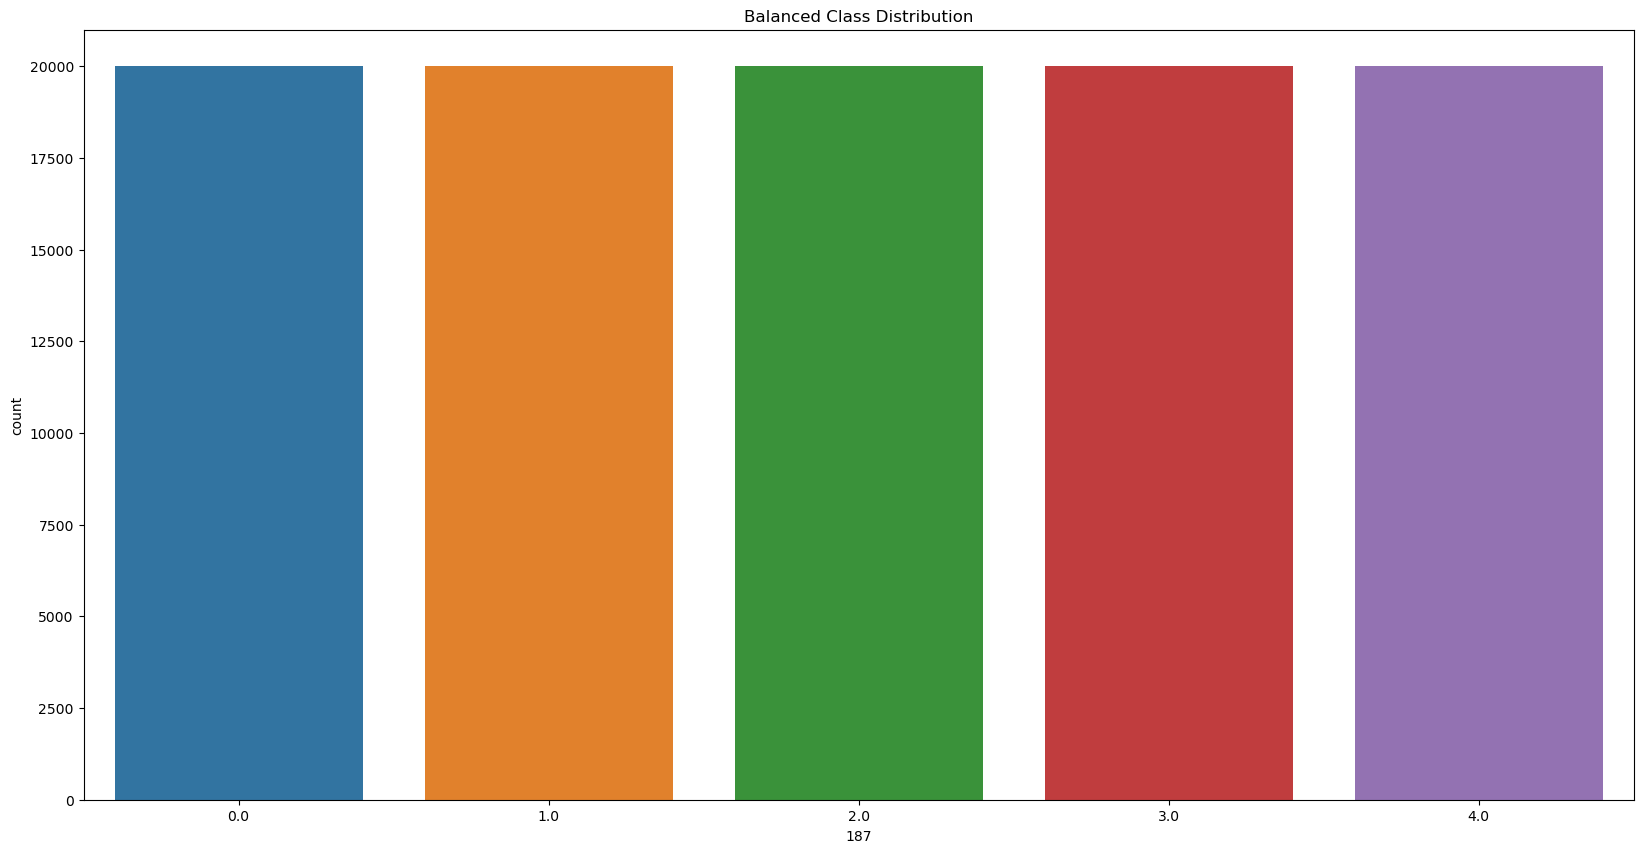

In [101]:
plot_class_distribution(train_df_balanced[187], "Balanced Class Distribution")

# Function to plot ECG for each class

In [102]:
def plot_ecg_samples(df):
    classes = df.groupby(187, group_keys=False).apply(lambda x: x.sample(1))
    plt.figure(figsize=(16, 8))
    for i, (idx, row) in enumerate(classes.iterrows()):
        plt.subplot(2, 3, i + 1)
        plt.plot(row[:186])
        plt.title(f'Class {i} ECG Sample')
    plt.show()


# Plot ECG samples for each class

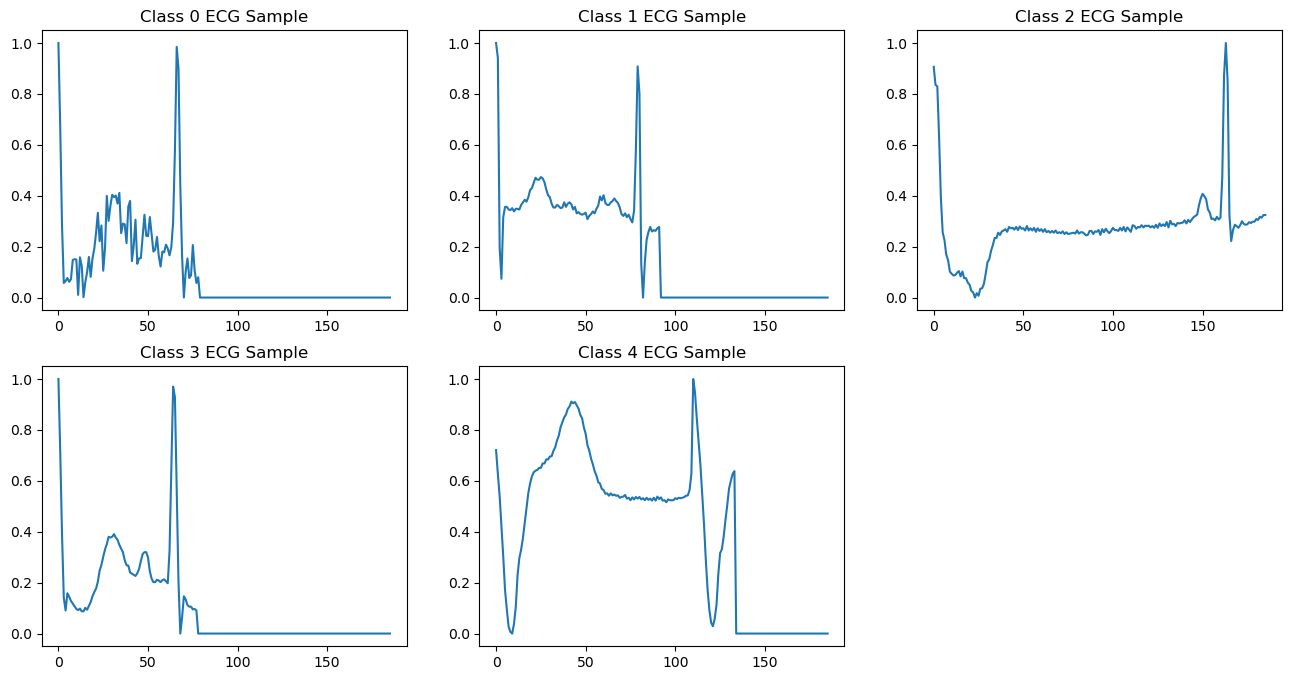

In [103]:
plot_ecg_samples(train_df_balanced)

# Function to plot ECG with and without Gaussian noise

In [104]:
def plot_ecg_with_noise(classes, class_num, noise_level=0.05):
    plt.figure(figsize=(12, 4))

    # Original ECG
    plt.subplot(2, 1, 1)
    plt.plot(classes.iloc[class_num, :186])
    plt.title(f'Class {class_num} ECG Sample')

    # ECG with Gaussian noise
    noise = np.random.normal(0, noise_level, 186)
    noisy_ecg = classes.iloc[class_num, :186] + noise
    plt.subplot(2, 1, 2)
    plt.plot(noisy_ecg)
    plt.title(f'Class {class_num} ECG Sample with Noise')
    plt.show()


# Function to plot histogram for ECG classes

In [105]:
def plot_ecg_histogram(class_num, start, end):
    ecg_data = train_df[train_df[187] == class_num].iloc[:, start:end].values
    ecg_flattened = ecg_data.flatten()
    time_points = np.arange(start, end)

    # Repeat time points for all ECG samples
    time_points_repeated = np.tile(time_points, len(ecg_data))

    plt.hist2d(time_points_repeated, ecg_flattened, bins=(80, 80), cmap=plt.cm.jet)
    plt.show()

# Prepare target variables for training

In [106]:
target_train = train_df[187]
target_test = test_df[187]
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

# Prepare input variables for training

In [107]:
X_train = train_df.iloc[:, :186].values.reshape(len(train_df), 186, 1)
X_test = test_df.iloc[:, :186].values.reshape(len(test_df), 186, 1)

# Plot ECG and histogram for different classes

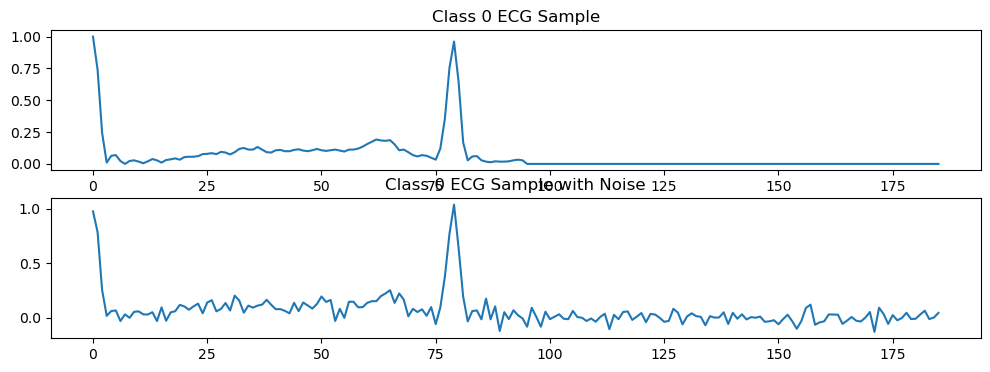

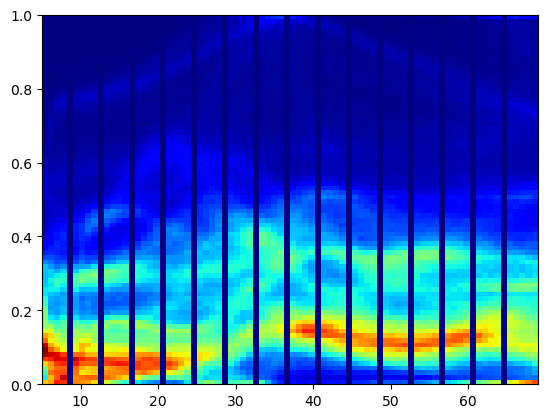

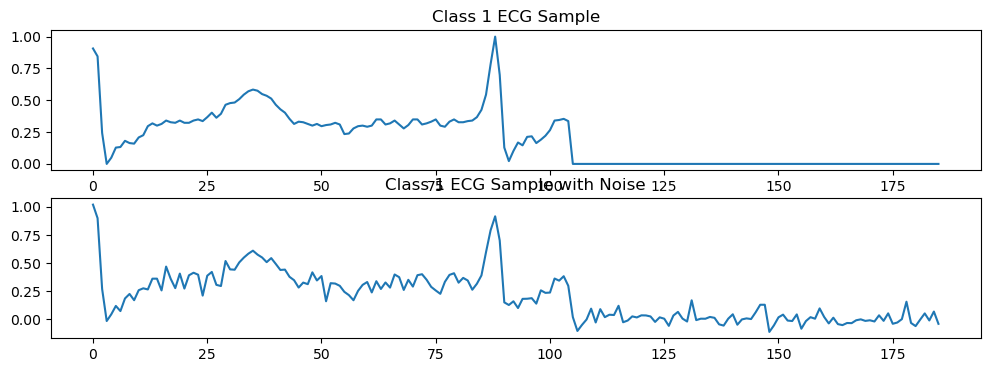

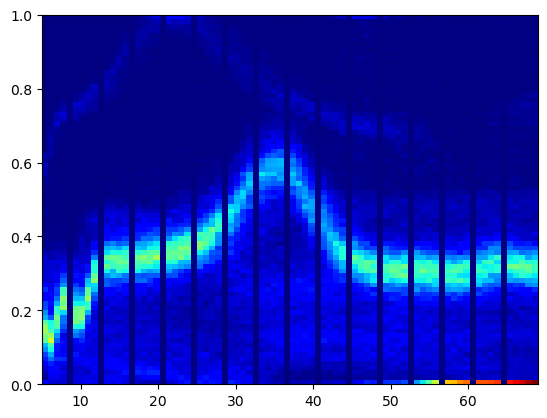

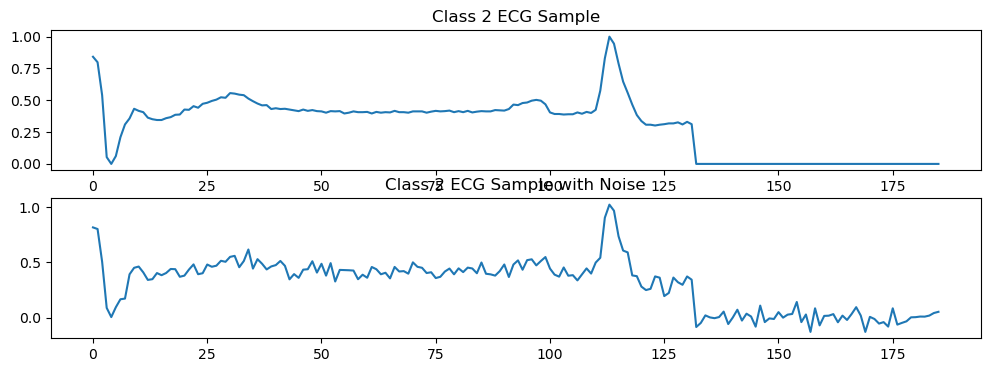

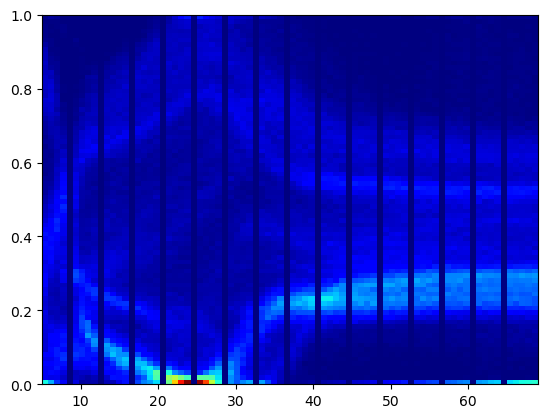

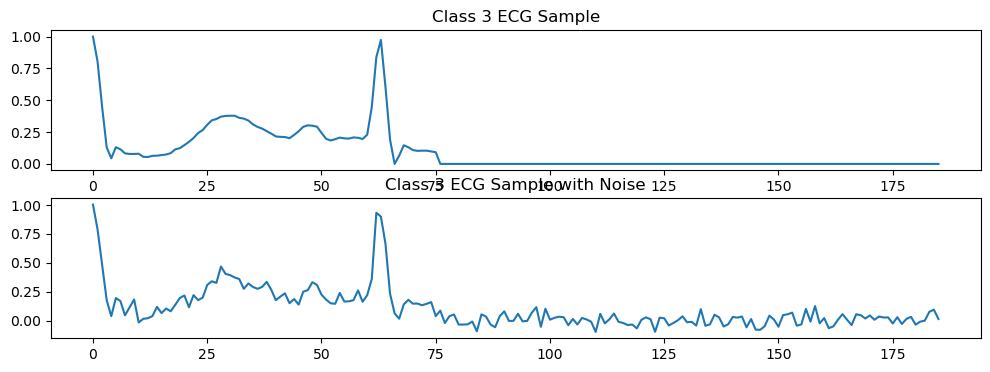

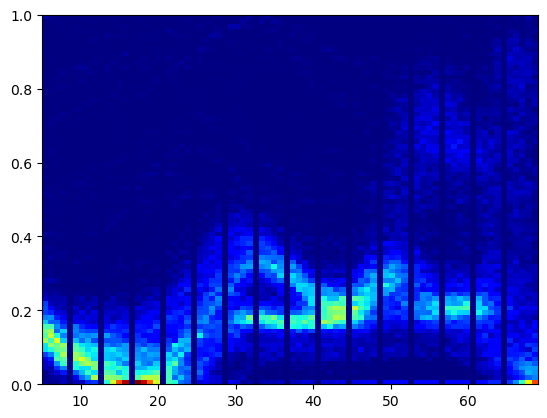

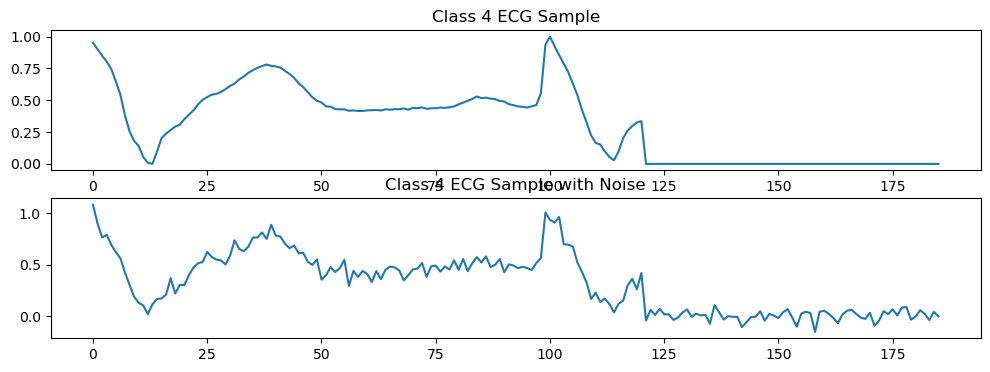

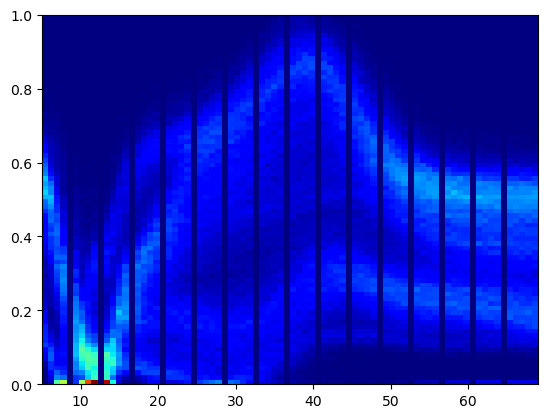

In [108]:
classes = train_df_balanced.groupby(187, group_keys=False).apply(lambda x: x.sample(1))
for i in range(5):
    plot_ecg_with_noise(classes, i)
    plot_ecg_histogram(i, 5, 70)

In [109]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
import warnings
warnings.filterwarnings("ignore")

# Create CNN Network

In [110]:
def create_cnn_network(input_shape, output_units=5):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 6, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(3, 2, padding="same")(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(2, 2, padding="same")(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(output_units, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluate Model

In [111]:
def evaluate_model(model, X_test, y_test, history):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: {:.2f}%".format(scores[1] * 100))

    # Plot Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()

# Plot Confusion Matrix

In [114]:

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "darkgreen"
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Main Execution

Epoch 1/5
2737/2737 [==============================] - 18s 7ms/step - loss: 0.1306 - accuracy: 0.9628 - val_loss: 0.0991 - val_accuracy: 0.9746
Epoch 2/5
2737/2737 [==============================] - 17s 6ms/step - loss: 0.0731 - accuracy: 0.9780 - val_loss: 0.0945 - val_accuracy: 0.9736
Epoch 3/5
2737/2737 [==============================] - 17s 6ms/step - loss: 0.0553 - accuracy: 0.9834 - val_loss: 0.0658 - val_accuracy: 0.9816
Epoch 4/5
2737/2737 [==============================] - 17s 6ms/step - loss: 0.0444 - accuracy: 0.9864 - val_loss: 0.0776 - val_accuracy: 0.9781
Epoch 5/5
2737/2737 [==============================] - 17s 6ms/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 0.0867 - val_accuracy: 0.9812
Accuracy: 98.16%


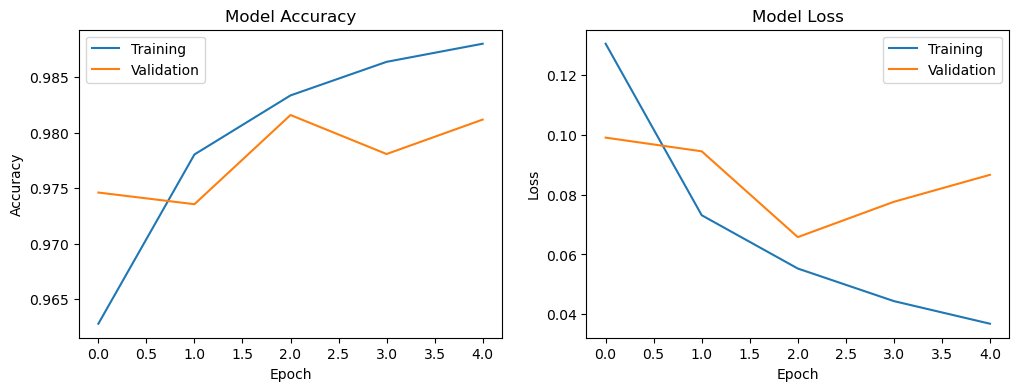

685/685 [==============================] - 1s 2ms/step


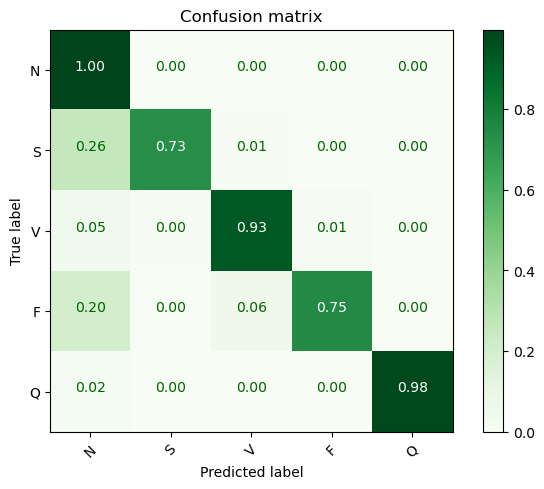

In [115]:
input_shape = (X_train.shape[1], 1)
model = create_cnn_network(input_shape)

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint('best_model.h5', save_best_only=True)]
history = model.fit(X_train, y_train, epochs=5, batch_size=32, callbacks=callbacks, validation_data=(X_test, y_test))
model.load_weights('best_model.h5')

evaluate_model(model, X_test, y_test, history)

y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'], normalize=True)